In [1]:
# !pip install kagglehub
# !pip install pydot graphviz

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
import os
import kagglehub

# Download the Brain Tumor MRI dataset from Kaggle
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Dataset stored at:", path)
print("Files:", os.listdir(path))

c:\Users\sanjy\anaconda3\envs\tfd10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset stored at: C:\Users\sanjy\.cache\kagglehub\datasets\masoudnickparvar\brain-tumor-mri-dataset\versions\1
Files: ['Testing', 'Training']


In [4]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

In [5]:
# defining the training and testing directories
train_dir = os.path.join(path, "Training")
test_dir  = os.path.join(path, "Testing")

In [6]:
# defining the categories
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [7]:
train_data = []

# loop through each category
for cat in categories:

    # get path to the category folder
    folder_path = os.path.join(train_dir, cat)

    # list all image filenames inside that category
    images = os.listdir(folder_path)
    
    # count how many images are in this category
    count = len(images)
    
    # create a df for this category where each row = one image
    train_data.append(
        pd.DataFrame({"Image": images, 
                      "Category": [cat] * count, 
                      "Count": [count] * count})
    )

# combine all category dataframes into one df
train_df = pd.concat(train_data, ignore_index=True)

In [8]:
train_df

,Image,Category,Count
0,Tr-glTr_0000.jpg,glioma,1321
1,Tr-glTr_0001.jpg,glioma,1321
2,Tr-glTr_0002.jpg,glioma,1321
3,Tr-glTr_0003.jpg,glioma,1321
4,Tr-glTr_0004.jpg,glioma,1321
...,...,...,...
5707,Tr-pi_1452.jpg,pituitary,1457
5708,Tr-pi_1453.jpg,pituitary,1457
5709,Tr-pi_1454.jpg,pituitary,1457
5710,Tr-pi_1455.jpg,pituitary,1457


In [9]:
train_df['Category'].value_counts()

Category
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64

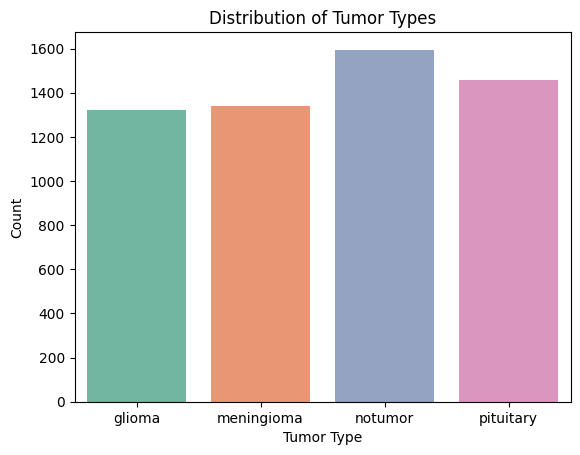

In [10]:
# visualizing the dataset distribution

sns.barplot(data=train_df, x='Category', y='Count', palette='Set2')
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

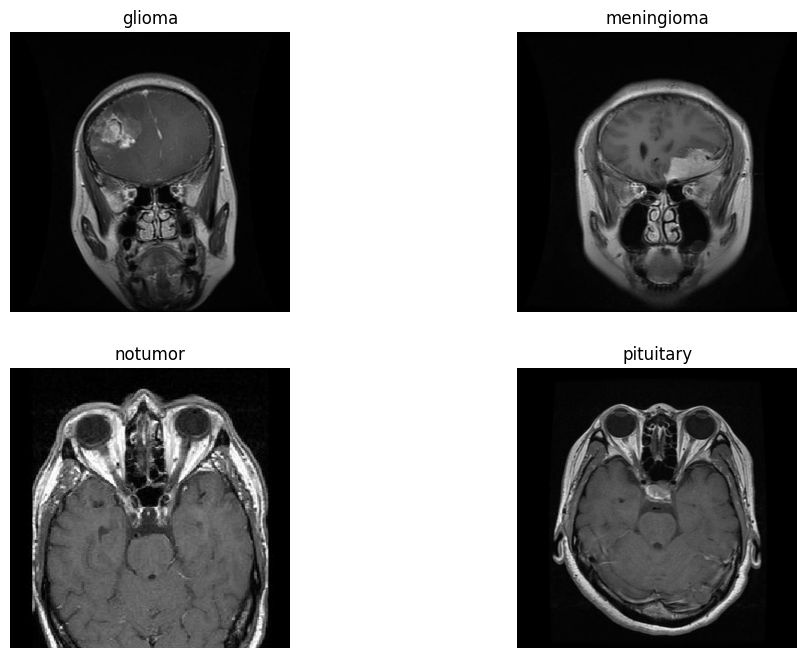

In [11]:
# visualizing sample images for each tumor type

plt.figure(figsize=(12, 8))

# loop through categories and pick first image from each
for i, cat in enumerate(categories):
    
    # path to category folder
    folder_path = os.path.join(train_dir, cat)
    
    # take first image
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    
    # read image
    img = plt.imread(image_path)
    
    # plot image
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(cat)
    plt.axis("off")

plt.show()

In [12]:
# all images will be resized to 150x150 pixels before training
image_size = (150, 150)

# how many images are processed in each training batch
batch_size = 32

# how many times the entire training dataset is iterated
epochs = 50

In [13]:
# data augmentation and preprocessing

# create training data generator with augmentation
# we use augmentation only on training data to make the model more robust
# we don't augment test data because we need to evaluate on real/original images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

# load training images in batches from train_dir using train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

# create testing data generator - only rescaling, no augmentation
# testing should be on clean data so we can measure true performance
test_datagen = ImageDataGenerator(rescale=1./255)

# load testing images in batches from test_dir using test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [14]:
# define the model architecture
model = Sequential()

# first convolution layer with 32 filters of size 3x3 and relu activation
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(image_size[0], image_size[1], 3)))

# first max pooling layer with pool size 2x2
model.add(MaxPooling2D((2, 2)))

# second convolution layer with 64 filters
model.add(Conv2D(64, (3, 3), activation="relu"))

# second max pooling layer
model.add(MaxPooling2D((2, 2)))

# third convolution layer with 128 filters
model.add(Conv2D(128, (3, 3), activation="relu"))

# third max pooling layer
model.add(MaxPooling2D((2, 2)))

# fourth convolution layer with 128 filters
model.add(Conv2D(128, (3, 3), activation="relu"))

# fourth max pooling layer
model.add(MaxPooling2D((2, 2)))

# flatten layer to convert 2d feature maps into 1d vector
model.add(Flatten())

# dense (fully connected) layer with 512 neurons and relu activation
model.add(Dense(512, activation="relu"))

# dropout layer (50%) to reduce overfitting
model.add(Dropout(0.5))

# output layer with 4 neurons (one for each tumor type) and softmax activation
model.add(Dense(4, activation="softmax"))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

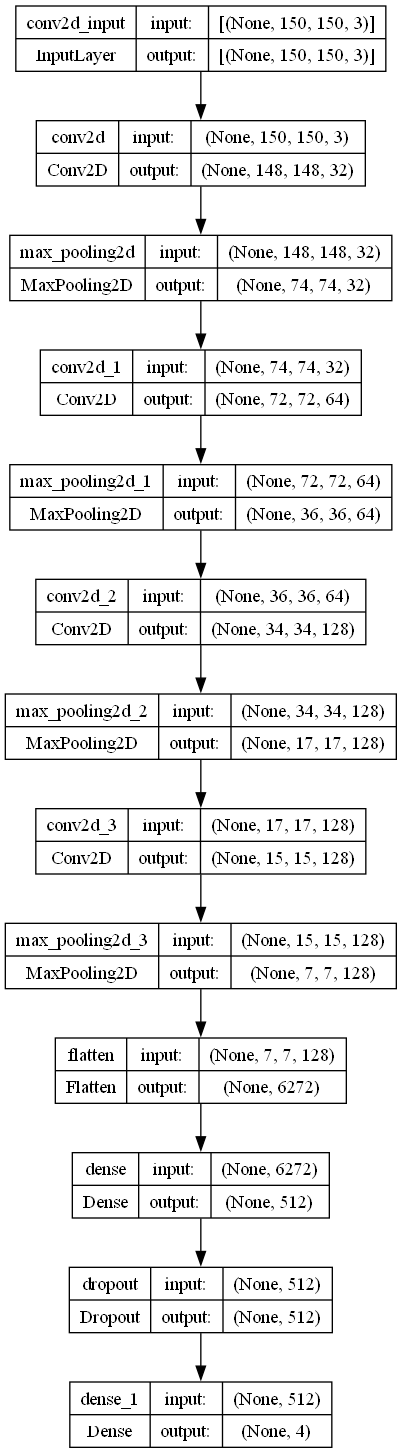

In [16]:
# plot model architecture as image

plot_model(model, to_file="cnn_model.png", show_shapes=True, show_layer_names=True)

In [17]:
# compiling the model

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [18]:
# save the best model during training (based on val_accuracy)

checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

In [19]:
# training the model

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,  # no. of batches per epoch
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = test_generator.samples // batch_size,   # no. of batches for validation
    callbacks=[checkpoint]
)

Epoch 1/50
178/178 [==============================] - ETA: 0s - loss: 0.9855 - accuracy: 0.5583
Epoch 1: val_accuracy improved from -inf to 0.50625, saving model to best_model.keras
178/178 [==============================] - 20s 111ms/step - loss: 0.9855 - accuracy: 0.5583 - val_loss: 1.3110 - val_accuracy: 0.5063
Epoch 2/50
178/178 [==============================] - ETA: 0s - loss: 0.7025 - accuracy: 0.7129
Epoch 2: val_accuracy did not improve from 0.50625
178/178 [==============================] - 17s 98ms/step - loss: 0.7025 - accuracy: 0.7129 - val_loss: 1.7610 - val_accuracy: 0.4422
Epoch 3/50
178/178 [==============================] - ETA: 0s - loss: 0.6442 - accuracy: 0.7475
Epoch 3: val_accuracy improved from 0.50625 to 0.71328, saving model to best_model.keras
178/178 [==============================] - 30s 169ms/step - loss: 0.6442 - accuracy: 0.7475 - val_loss: 0.7142 - val_accuracy: 0.7133
Epoch 4/50
178/178 [==============================] - ETA: 0s - loss: 0.5690 - accura

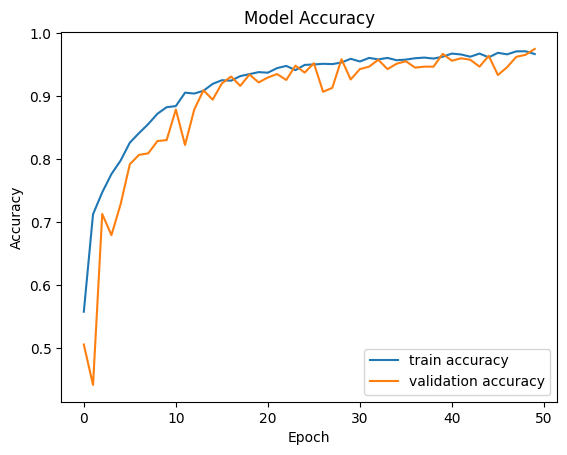

In [20]:
# plot training and validation accuracy

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

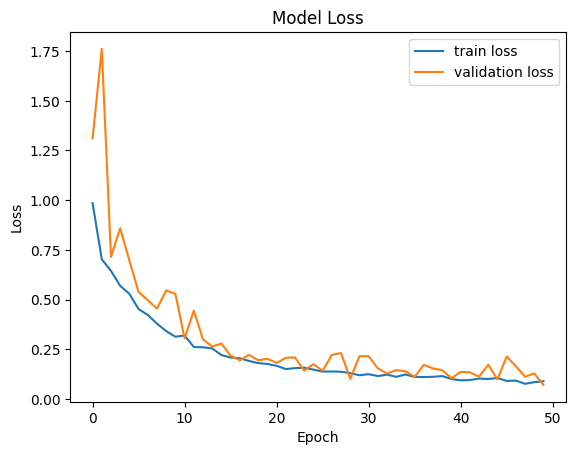

In [21]:
# plot training and validation loss

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
# load the best model
best_model = load_model("best_model.keras")

In [23]:
# evaluating the model on test data
loss, accuracy = best_model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

40/40 [==============================] - 2s 43ms/step - loss: 0.0704 - accuracy: 0.9750
Test Loss: 0.07044344395399094
Test Accuracy: 0.9750000238418579


41/41 [==============================] - 2s 40ms/step


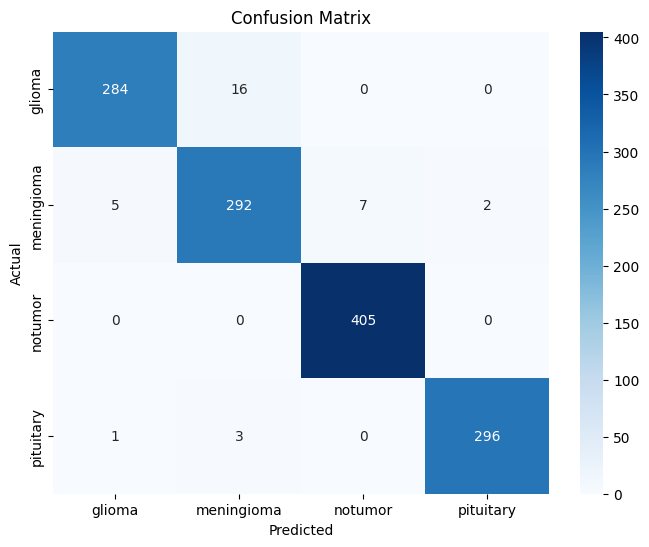

In [24]:
# make predictions on test dataset
predictions = best_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# confusion matrix
matrix = tf.math.confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [25]:
# classification report

report = classification_report(true_classes, predicted_classes, target_names=categories)
print(report)

              precision    recall  f1-score   support

      glioma       0.98      0.95      0.96       300
  meningioma       0.94      0.95      0.95       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



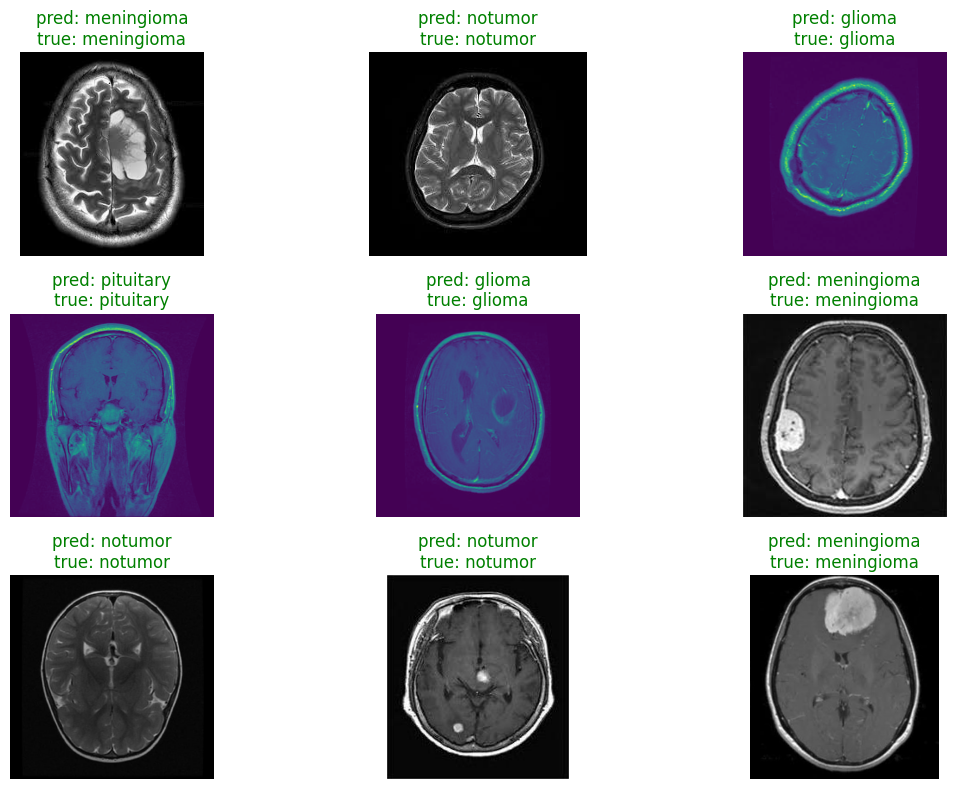

In [26]:
# select 9 random images from test set
sample_indices = np.random.choice(range(len(test_generator.filenames)), size=9, replace=False)
sample_images = [test_generator.filenames[i] for i in sample_indices]
sample_preds = [categories[predicted_classes[i]] for i in sample_indices]
sample_true = [categories[true_classes[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    
    # plot the images in a 3x3 grid
    plt.subplot(3, 3, i+1)
    
    # read the image
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    
    # check if the prediction is correct
    if sample_preds[i] == sample_true[i]:
        color = 'green'
    else:
        color = 'red'
    
    plt.title(f"pred: {sample_preds[i]}\ntrue: {sample_true[i]}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()